　「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第9章 動的一般化線形モデル：ポアソン分布を仮定した例」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　この章では，ポアソン分布を仮定したDGLMの実装例が紹介されています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# 自作のplotSSM関数を読み込み
from plotSSM import plotSSM

## データの読み込み

In [2]:
fish_ts = pd.read_csv('5-9-1-fish-num-ts.csv')
fish_ts['date'] = pd.to_datetime(fish_ts['date'])
fish_ts.head(n=3)

,date,fish_num,temperature
0,2010-01-01,2,1.8
1,2010-01-02,1,7.0
2,2010-01-03,2,5.7


## 図示

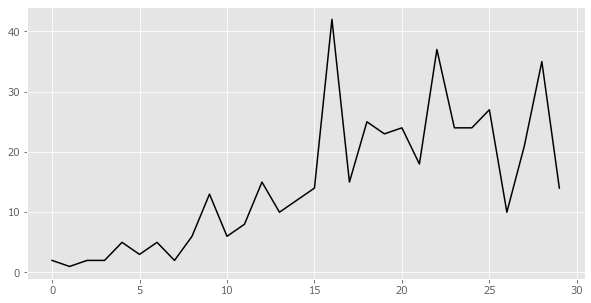

In [4]:
plt.figure(figsize=(10,5))
plt.plot(fish_ts['fish_num'], color='black')
plt.show()

# モデルの推定
## データの準備

In [5]:
data_list = dict(y=fish_ts['fish_num'],
                 ex=fish_ts['temperature'],
                 T=len(fish_ts))

## モデルの推定

In [ ]:
# stanコードの記述（5-8-1-dglm-binom.stan）
stan_code = '''
data {
  int T;        // データ取得期間の長さ
  vector[T] ex; // 説明変数
  int y[T];     // 観測値
}

parameters {
  vector[T] mu;       // 水準+ドリフト成分の推定値
  vector[T] r;        // ランダム効果
  real b;             // 係数の推定値
  real<lower=0> s_z;  // ドリフト成分の変動の大きさを表す標準偏差
  real<lower=0> s_r;  // ランダム効果の標準偏差
}

transformed parameters {
  vector[T] lambda;   // 観測値の期待値のlogをとった値
  
  for(i in 1:T) {
    lambda[i] = mu[i] + b * ex[i] + r[i];
  }

}

model {
  // 時点ごとに加わるランダム効果
  r ~ normal(0, s_r);
  
  // 状態方程式に従い、状態が遷移する
  for(i in 3:T) {
    mu[i] ~ normal(2 * mu[i-1] - mu[i-2], s_z);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ poisson_log(lambda[i]);
  }

}

generated quantities {
  // 状態推定値（EXP）
  vector[T] lambda_exp;
  // ランダム効果除外の状態推定値
  vector[T] lambda_smooth;
  // ランダム効果除外、説明変数固定の状態推定値
  vector[T] lambda_smooth_fix; 

  lambda_exp = exp(lambda);
  lambda_smooth = exp(mu + b * ex);
  lambda_smooth_fix = exp(mu + b * mean(ex));
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
dglm_poisson = stan_model.sampling(data=data_list,
                                   seed=1,
                                   iter=8000,
                                   warmup=2000,
                                   thin=6,
                                   control={
                                       'adapt_delta': 0.99,
                                       'max_treedepth': 15
                                   },
                                   n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e7f96660af24f75fe7e27f7ed8f7131 NOW.


## 推定されたパラメタ

In [ ]:
print(dglm_poisson.stansummary(pars=["s_z", "s_r", "b", "lp__"], probs=[0.025, 0.5, 0.975]))

## 参考：収束の確認

In [ ]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(dglm_poisson.summary()['summary'],
                       columns=dglm_poisson.summary()['summary_colnames'],
                       index=dglm_poisson.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

In [ ]:
print('hmc_diagnostics:\n',
      pystan.diagnostics.check_hmc_diagnostics(dglm_poisson))